In [2]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

/home/cent/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cent/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cent/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cent/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [3]:

pickle_file = 'notMNIST.pickle'
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)
                        
                         

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [4]:
image_size = 28
num_labels = 10
num_channels = 1
import numpy as np 

def reformat(dataset, labels):
    dataset = dataset.reshape(
        (-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
                                              

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [5]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

In [35]:
batch_size = 16
patch_size = 5 
depth = 16
num_hidden = 64
num_steps = 10001
graph = tf.Graph()

with graph.as_default():
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    layer1_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    
    layer2_pool_biases = tf.Variable(tf.zeros([depth]))
    
    layer3_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, depth, depth], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
          
    layer4_pool_biases = tf.Variable(tf.zeros([depth]))
    
    layer5_weights = tf.Variable(tf.truncated_normal(
        [64, num_hidden], stddev=0.1))
    layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    
    layer6_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    layer6_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
                                
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        
        pool = tf.nn.max_pool(hidden, 2, 2, padding='SAME')
        hidden = tf.nn.relu(pool + layer2_pool_biases)
        
        conv = tf.nn.conv2d(hidden, layer3_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer3_biases)
        
        pool = tf.nn.max_pool(hidden, 2, 2, padding='SAME')
        hidden = tf.nn.relu(pool + layer4_pool_biases)
        
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        #hidden = tf.nn.relu(tf.nn.dropout(tf.matmul(reshape, layer5_weights) + layer5_biases,rate = 0.2))
        hidden = tf.nn.relu(tf.matmul(reshape, layer5_weights) + layer5_biases)
        return tf.matmul(hidden, layer6_weights) + layer6_biases
    
                                
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    global_step = tf.Variable(0, trainable=False)

    initial_learning_rate = 0.05 #初始学习率
    learning_rate = tf.train.exponential_decay(initial_learning_rate,
                                           global_step=num_steps,
                                           decay_steps=100,decay_rate=0.99)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 2.556909
Minibatch accuracy: 12.5%
Validation accuracy: 9.7%
Minibatch loss at step 50: 2.278924
Minibatch accuracy: 6.2%
Validation accuracy: 14.0%
Minibatch loss at step 100: 2.284628
Minibatch accuracy: 18.8%
Validation accuracy: 24.4%
Minibatch loss at step 150: 2.207000
Minibatch accuracy: 18.8%
Validation accuracy: 27.6%
Minibatch loss at step 200: 1.838336
Minibatch accuracy: 43.8%
Validation accuracy: 31.8%
Minibatch loss at step 250: 1.922851
Minibatch accuracy: 37.5%
Validation accuracy: 37.6%
Minibatch loss at step 300: 1.243365
Minibatch accuracy: 62.5%
Validation accuracy: 60.4%
Minibatch loss at step 350: 1.274770
Minibatch accuracy: 75.0%
Validation accuracy: 61.4%
Minibatch loss at step 400: 1.417681
Minibatch accuracy: 68.8%
Validation accuracy: 64.7%
Minibatch loss at step 450: 0.996180
Minibatch accuracy: 75.0%
Validation accuracy: 70.8%
Minibatch loss at step 500: 0.554082
Minibatch accuracy: 87.5%
Validation accuracy: 74.9%
Min

Validation accuracy: 84.0%
Minibatch loss at step 4550: 0.688917
Minibatch accuracy: 81.2%
Validation accuracy: 84.0%
Minibatch loss at step 4600: 0.147864
Minibatch accuracy: 100.0%
Validation accuracy: 83.8%
Minibatch loss at step 4650: 0.595191
Minibatch accuracy: 81.2%
Validation accuracy: 84.3%
Minibatch loss at step 4700: 0.384975
Minibatch accuracy: 81.2%
Validation accuracy: 83.8%
Minibatch loss at step 4750: 0.345345
Minibatch accuracy: 87.5%
Validation accuracy: 83.8%
Minibatch loss at step 4800: 0.322225
Minibatch accuracy: 93.8%
Validation accuracy: 84.4%
Minibatch loss at step 4850: 0.520558
Minibatch accuracy: 87.5%
Validation accuracy: 84.2%
Minibatch loss at step 4900: 0.223934
Minibatch accuracy: 93.8%
Validation accuracy: 84.1%
Minibatch loss at step 4950: 0.334783
Minibatch accuracy: 93.8%
Validation accuracy: 84.2%
Minibatch loss at step 5000: 1.368931
Minibatch accuracy: 43.8%
Validation accuracy: 84.1%
Minibatch loss at step 5050: 0.293857
Minibatch accuracy: 93.8

Validation accuracy: 86.0%
Minibatch loss at step 9050: 0.543689
Minibatch accuracy: 75.0%
Validation accuracy: 85.8%
Minibatch loss at step 9100: 0.232800
Minibatch accuracy: 93.8%
Validation accuracy: 85.7%
Minibatch loss at step 9150: 0.647891
Minibatch accuracy: 81.2%
Validation accuracy: 85.9%
Minibatch loss at step 9200: 0.713674
Minibatch accuracy: 81.2%
Validation accuracy: 85.9%
Minibatch loss at step 9250: 1.036122
Minibatch accuracy: 68.8%
Validation accuracy: 85.9%
Minibatch loss at step 9300: 0.965611
Minibatch accuracy: 75.0%
Validation accuracy: 85.9%
Minibatch loss at step 9350: 0.075202
Minibatch accuracy: 100.0%
Validation accuracy: 85.8%
Minibatch loss at step 9400: 0.385764
Minibatch accuracy: 93.8%
Validation accuracy: 85.9%
Minibatch loss at step 9450: 0.316429
Minibatch accuracy: 87.5%
Validation accuracy: 86.3%
Minibatch loss at step 9500: 0.593926
Minibatch accuracy: 81.2%
Validation accuracy: 85.5%
Minibatch loss at step 9550: 0.254662
Minibatch accuracy: 87.5

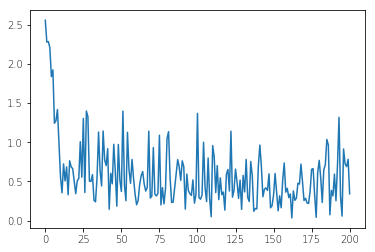

In [36]:

losses = []
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset :batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            losses.append(l)
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
    import matplotlib.pyplot as plt
    plt.plot(losses)